## TASK 1 (RT-DETR)

C:\Users\worka\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\worka\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
OpenCV Version: 4.12.0
OpenCV Version: 4.12.0


100%|██████████| 200M/200M [01:11<00:00, 2.96MB/s] 

Extracting files...



✓ Dataset downloaded to: C:\Users\worka\.cache\kagglehub\datasets\simuletic\cctv-weapon-dataset\versions\4

Dataset structure:
4/
  evaluation.mp4
  Dataset/
    annotation_sample.csv
    images/
    labels/

✓ Found 141 images in dataset
Loading RT-DETR Model

Loading RT-DETR-l model (this may take a moment on first run)...
✓ RT-DETR model loaded successfully!

Model can detect 80 object classes
Sample classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']

STEP 4: Testing RT-DETR on Sample Images

Processing 6 sample images...
✓ RT-DETR model loaded successfully!

Model can detect 80 object classes
Sample classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']

STEP 4: Testing RT-DETR on Sample Images

Processing 6 sample images...

  Image 1: Scene1_1.png
    Inference time: 1644.8ms
    Objects detected: 1
      - person: 0.90

  Image 1: Scene1_1.png
    Inference 

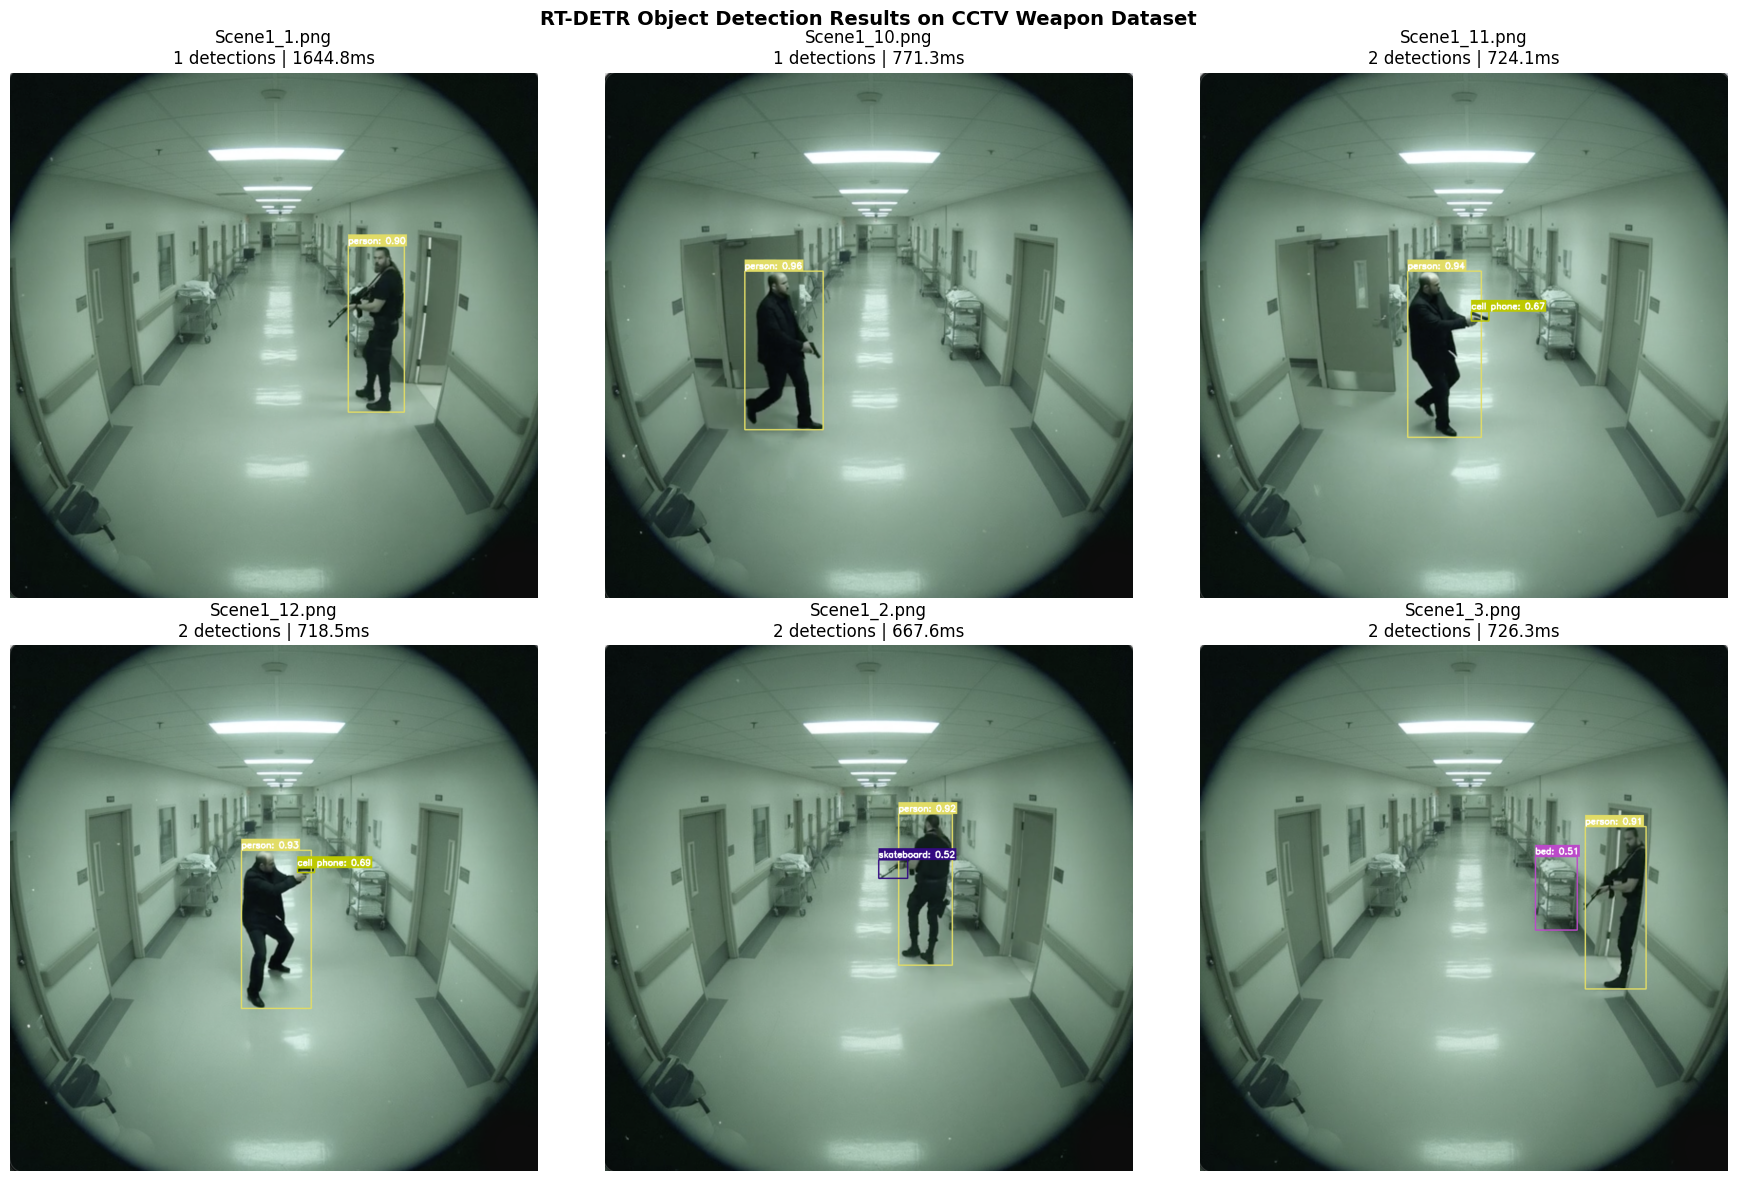

STEP 5: Real-Time Detection on Webcam

Controls:
  Q - Quit
  S - Save screenshot
  +/- - Adjust confidence threshold

Starting webcam feed...

Starting webcam feed...
Saved: rtdetr_capture_29.jpg
Saved: rtdetr_capture_29.jpg
Saved: rtdetr_capture_58.jpg
Saved: rtdetr_capture_58.jpg

Quitting...

Quitting...

Processed 64 frames
Average FPS: 1.28
SUMMARY

Objects detected in sample images:
  person: 6
  cell phone: 2
  skateboard: 1
  bed: 1

Average confidence score: 0.79
Average inference time: 875.4ms

✓ Results saved to 'rtdetr_detection_results.png'

Processed 64 frames
Average FPS: 1.28
SUMMARY

Objects detected in sample images:
  person: 6
  cell phone: 2
  skateboard: 1
  bed: 1

Average confidence score: 0.79
Average inference time: 875.4ms

✓ Results saved to 'rtdetr_detection_results.png'


In [ ]:
"""
Lab 10: Real-Time Object Detection using RT-DETR
Student: 22k-4080
Task: Weapon Detection on CCTV Dataset using RT-DETR Model
"""

# Install required packages
import subprocess
import sys

# def install_packages():
#     packages = ['kagglehub', 'ultralytics', 'opencv-python', 'torch', 'torchvision']
#     for pkg in packages:
#         try:
#             __import__(pkg.replace('-', '_').split('[')[0])
#         except ImportError:
#             print(f"Installing {pkg}...")
#             subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])

# install_packages()

# Import libraries
import kagglehub
import cv2
import numpy as np
import os
import time
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import RTDETR

print("OpenCV Version:", cv2.__version__)

# Download the dataset
path = kagglehub.dataset_download("simuletic/cctv-weapon-dataset")
print(f"\n✓ Dataset downloaded to: {path}")

# Explore dataset structure
print("\nDataset structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Only show first 2 levels
        for file in files[:5]:  # Show first 5 files
            print(f"{indent}  {file}")
        if len(files) > 5:
            print(f"{indent}  ... and {len(files)-5} more files")

# Find image files
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(path, '**', ext), recursive=True))

print(f"\n✓ Found {len(image_files)} images in dataset")


print("Loading RT-DETR Model")

# Load RT-DETR model (using Ultralytics implementation)
# RT-DETR-l is a good balance of speed and accuracy
print("\nLoading RT-DETR-l model (this may take a moment on first run)...")
model = RTDETR('rtdetr-l.pt')  # Will auto-download if not present
print("✓ RT-DETR model loaded successfully!")

# Get class names from model
class_names = model.names
print(f"\nModel can detect {len(class_names)} object classes")
print("Sample classes:", list(class_names.values())[:10])

# Generate colors for each class
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)

def detect_objects(image, model, conf_threshold=0.5):
    """
    Detect objects in image using RT-DETR

    Args:
        image: Input image (BGR format)
        model: RT-DETR model
        conf_threshold: Confidence threshold for detections

    Returns:
        annotated_image: Image with bounding boxes
        detections: List of detection dictionaries
        inference_time: Time taken for inference
    """
    start_time = time.time()

    # Run inference
    results = model(image, conf=conf_threshold, verbose=False)[0]

    inference_time = time.time() - start_time

    # Process detections
    detections = []
    annotated_image = image.copy()

    if results.boxes is not None:
        boxes = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
        scores = results.boxes.conf.cpu().numpy()  # Confidence scores
        class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs

        for box, score, class_id in zip(boxes, scores, class_ids):
            x1, y1, x2, y2 = box.astype(int)
            class_name = class_names[class_id]
            color = [int(c) for c in colors[class_id]]

            # Store detection info
            detections.append({
                'class': class_name,
                'class_id': class_id,
                'confidence': float(score),
                'box': [x1, y1, x2, y2]
            })

            # Draw bounding box
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)

            # Draw label background
            label = f"{class_name}: {score:.2f}"
            (label_w, label_h), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
            )
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_h - 10),
                (x1 + label_w, y1),
                color, -1
            )

            # Draw label text
            cv2.putText(
                annotated_image, label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
            )

    return annotated_image, detections, inference_time

# ============================================================
# STEP 4: Test on Sample Images from Dataset
# ============================================================
print("\n" + "="*60)
print("STEP 4: Testing RT-DETR on Sample Images")
print("="*60)

# Select sample images
sample_images = image_files[:6] if len(image_files) >= 6 else image_files
print(f"\nProcessing {len(sample_images)} sample images...")

# Create figure for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

total_inference_time = 0
all_detections = []

for idx, img_path in enumerate(sample_images):
    # Read image
    image = cv2.imread(img_path)
    if image is None:
        print(f"  ✗ Could not read: {img_path}")
        continue

    # Detect objects
    annotated_image, detections, inference_time = detect_objects(image, model)
    total_inference_time += inference_time
    all_detections.extend(detections)

    # Print results
    print(f"\n  Image {idx+1}: {os.path.basename(img_path)}")
    print(f"    Inference time: {inference_time*1000:.1f}ms")
    print(f"    Objects detected: {len(detections)}")
    for det in detections:
        print(f"      - {det['class']}: {det['confidence']:.2f}")

    # Display in subplot
    if idx < len(axes):
        rgb_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(rgb_image)
        axes[idx].set_title(f"{os.path.basename(img_path)}\n{len(detections)} detections | {inference_time*1000:.1f}ms")
        axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(sample_images), len(axes)):
    axes[idx].axis('off')

plt.suptitle('RT-DETR Object Detection Results on CCTV Weapon Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('rtdetr_detection_results.png', dpi=150, bbox_inches='tight')
plt.show()


print("STEP 5: Real-Time Detection on Webcam")
print("="*60)
print("\nControls:")
print("  Q - Quit")
print("  S - Save screenshot")
print("  +/- - Adjust confidence threshold")
print("="*60)

def run_realtime_detection():
    """Run real-time object detection on webcam"""
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam")
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    conf_threshold = 0.5
    fps_history = []
    frame_count = 0

    print("\nStarting webcam feed...")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            frame_count += 1

            # Run detection
            annotated_frame, detections, inference_time = detect_objects(
                frame, model, conf_threshold
            )

            # Calculate FPS
            fps = 1 / inference_time if inference_time > 0 else 0
            fps_history.append(fps)
            if len(fps_history) > 30:
                fps_history.pop(0)
            avg_fps = np.mean(fps_history)

            # Draw info panel
            h, w = annotated_frame.shape[:2]

            # Background for info
            cv2.rectangle(annotated_frame, (w-250, 0), (w, 120), (0, 0, 0), -1)

            # Info text
            info_texts = [
                f"RT-DETR Detection",
                f"FPS: {avg_fps:.1f}",
                f"Inference: {inference_time*1000:.1f}ms",
                f"Detections: {len(detections)}",
                f"Conf: {conf_threshold:.2f}"
            ]

            for i, text in enumerate(info_texts):
                color = (0, 255, 0) if i == 0 else (255, 255, 255)
                cv2.putText(
                    annotated_frame, text,
                    (w-240, 20 + i*20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1
                )

            # Controls hint
            cv2.putText(
                annotated_frame, "Q:Quit | S:Save | +/-:Conf",
                (10, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1
            )

            # Show frame
            cv2.imshow('RT-DETR Real-Time Detection', annotated_frame)

            # Handle keyboard
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\nQuitting...")
                break
            elif key == ord('s'):
                filename = f"rtdetr_capture_{frame_count}.jpg"
                cv2.imwrite(filename, annotated_frame)
                print(f"Saved: {filename}")
            elif key == ord('+') or key == ord('='):
                conf_threshold = min(0.95, conf_threshold + 0.05)
                print(f"Confidence threshold: {conf_threshold:.2f}")
            elif key == ord('-'):
                conf_threshold = max(0.1, conf_threshold - 0.05)
                print(f"Confidence threshold: {conf_threshold:.2f}")

    finally:
        cap.release()
        cv2.destroyAllWindows()
        print(f"\nProcessed {frame_count} frames")
        print(f"Average FPS: {np.mean(fps_history):.2f}")

# Run real-time detection
run_realtime_detection()


print("SUMMARY")

# Analyze detections from sample images
if all_detections:
    from collections import Counter
    class_counts = Counter([d['class'] for d in all_detections])

    print("\nObjects detected in sample images:")
    for class_name, count in class_counts.most_common(10):
        print(f"  {class_name}: {count}")

    avg_confidence = np.mean([d['confidence'] for d in all_detections])
    print(f"\nAverage confidence score: {avg_confidence:.2f}")

avg_inference = (total_inference_time / len(sample_images)) * 1000 if sample_images else 0
print(f"Average inference time: {avg_inference:.1f}ms")
print(f"\n✓ Results saved to 'rtdetr_detection_results.png'")

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.3 MB/s eta 0:00:00


# Task 2 (ViT and Comparison)

MODEL COMPARISON: ViT vs DETR vs RT-DETR
✓ GPU: Tesla T4

[1/3] Loading ViT (Vision Transformer) for Classification...
✓ ViT model loaded

[2/3] Loading DETR for Object Detection...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ DETR model loaded

[3/3] Loading RT-DETR for Real-Time Object Detection...
✓ RT-DETR model loaded

✓ All models loaded successfully!

STEP 2: Loading Dataset
Using Colab cache for faster access to the 'cctv-weapon-dataset' dataset.
✓ Dataset path: /kaggle/input/cctv-weapon-dataset
✓ Found images in: /kaggle/input/cctv-weapon-dataset/Dataset/images
✓ Using 20 test images for comparison

Processing 20 images with all 3 models...
----------------------------------------------------------------------

[1/20] Scene2_7.png
  ViT: binoculars, field glasses, ope (0.14) - 52.7ms
  DETR: 8 objects (avg conf: 0.60) - 106.9ms
  RT-DETR: 3 objects (avg conf: 0.63) - 1220.3ms

[2/20] Scene3_25.png
  ViT: gas pump, gasoline pump, petro (0.71) - 312.5ms
  DETR: 2 objects (avg conf: 1.00) - 542.9ms
  RT-DETR: 7 objects (avg conf: 0.49) - 309.9ms

[3/20] Scene1_2.png
  ViT: prison, prison house (0.96) - 185.6ms
  DETR: 15 objects (avg conf: 0.57) - 400.2ms
  RT-DETR: 2 objects (avg conf: 0.72) - 240.6

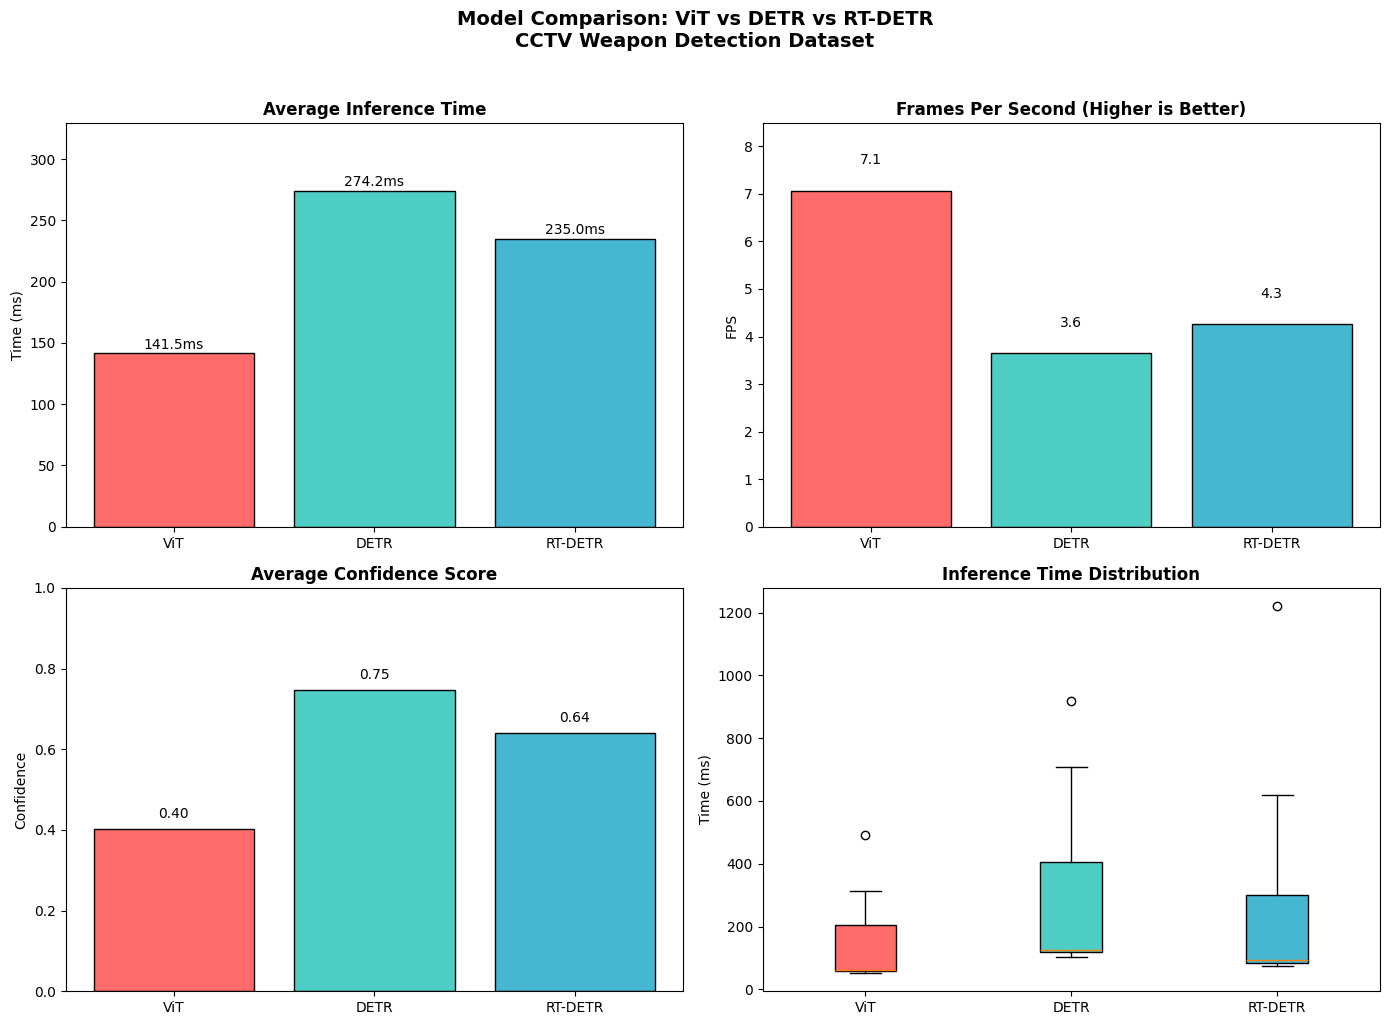


Comparing detections on: Scene2_7.png


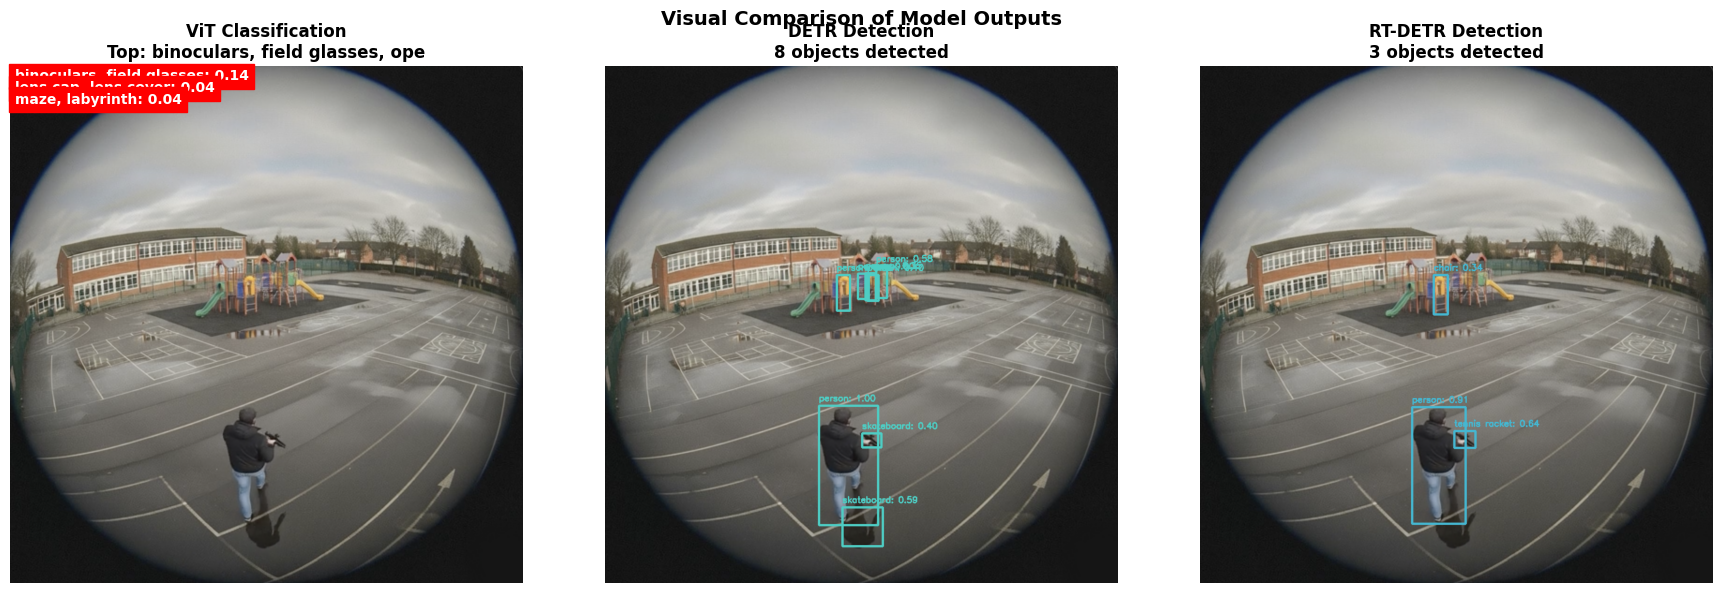


📊 Model Characteristics:
----------------------------------------------------------------------
Model        Type                      Best For                      
----------------------------------------------------------------------
ViT          Image Classification      Categorizing entire images    
DETR         Object Detection          Accurate detection, slower    
RT-DETR      Real-Time Detection       Fast detection, real-time apps

📈 Performance Summary:
----------------------------------------------------------------------
  🏆 Fastest Model: ViT (141.5ms, 7.1 FPS)
  🎯 Highest Confidence: DETR (0.75)

📁 Output Files:
  ✓ model_comparison_results.png - Performance charts
  ✓ visual_comparison.png - Side-by-side detection comparison


In [6]:
# task 2

import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


print("MODEL COMPARISON: ViT vs DETR vs RT-DETR")

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✓ GPU: {gpu_name}")
else:
    print("⚠ No GPU detected, using CPU")


try:
    from transformers import ViTForImageClassification, ViTImageProcessor
    from transformers import DetrForObjectDetection, DetrImageProcessor
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'transformers', '-q'])
    from transformers import ViTForImageClassification, ViTImageProcessor
    from transformers import DetrForObjectDetection, DetrImageProcessor

from ultralytics import RTDETR

# --- ViT Model (Image Classification) ---
print("\n[1/3] Loading ViT (Vision Transformer) for Classification...")
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
vit_model.to(device)
vit_model.eval()
print("✓ ViT model loaded")

# --- DETR Model (Object Detection) ---
print("\n[2/3] Loading DETR for Object Detection...")
detr_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
detr_model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
detr_model.to(device)
detr_model.eval()
print("✓ DETR model loaded")

# --- RT-DETR Model (Real-Time Object Detection) ---
print("\n[3/3] Loading RT-DETR for Real-Time Object Detection...")
rtdetr_model = RTDETR('rtdetr-l.pt')
print("✓ RT-DETR model loaded")

print("\n✓ All models loaded successfully!")

def classify_with_vit(image_path, top_k=5):
    """Classify image using ViT"""
    start_time = time.time()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = vit_processor(images=image, return_tensors="pt").to(device)

    # Inference
    with torch.no_grad():
        outputs = vit_model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

    inference_time = time.time() - start_time

    # Get top predictions
    top_probs, top_indices = torch.topk(probs[0], top_k)
    predictions = []
    for prob, idx in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
        label = vit_model.config.id2label[idx]
        predictions.append({'label': label, 'confidence': float(prob)})

    return predictions, inference_time

def detect_with_detr(image_path, threshold=0.5):
    """Detect objects using DETR"""
    start_time = time.time()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = detr_processor(images=image, return_tensors="pt").to(device)

    # Inference
    with torch.no_grad():
        outputs = detr_model(**inputs)

    inference_time = time.time() - start_time

    # Post-process
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = detr_processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    detections = []
    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        detections.append({
            'label': detr_model.config.id2label[label.item()],
            'confidence': float(score),
            'box': box.cpu().numpy().tolist()
        })

    return detections, inference_time

def detect_with_rtdetr(image_path, threshold=0.5):
    """Detect objects using RT-DETR"""
    start_time = time.time()

    # Inference
    results = rtdetr_model(image_path, conf=threshold, verbose=False)[0]

    inference_time = time.time() - start_time

    detections = []
    if results.boxes is not None:
        for box, score, cls in zip(
            results.boxes.xyxy.cpu().numpy(),
            results.boxes.conf.cpu().numpy(),
            results.boxes.cls.cpu().numpy()
        ):
            detections.append({
                'label': rtdetr_model.names[int(cls)],
                'confidence': float(score),
                'box': box.tolist()
            })

    return detections, inference_time

# ============================================================
# STEP 2: Download Dataset (if not already downloaded)
# ============================================================
print("\n" + "="*70)
print("STEP 2: Loading Dataset")
print("="*70)

import glob
import kagglehub

# Download dataset
path = kagglehub.dataset_download("simuletic/cctv-weapon-dataset")
print(f"✓ Dataset path: {path}")

# Dataset structure: 4/Dataset/images/ (images directly in folder, no train/val)
# Find images folder
test_images = []
possible_paths = [
    os.path.join(path, "4", "Dataset", "images"),
    os.path.join(path, "Dataset", "images"),
    os.path.join(path, "images"),
    path
]

for p in possible_paths:
    if os.path.exists(p):
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            test_images.extend(glob.glob(os.path.join(p, ext)))
            test_images.extend(glob.glob(os.path.join(p, '**', ext), recursive=True))
        if test_images:
            print(f"✓ Found images in: {p}")
            break

# Remove duplicates and limit
test_images = list(set(test_images))[:20]
print(f"✓ Using {len(test_images)} test images for comparison")


# Results storage
results = {
    'ViT': {'times': [], 'predictions': [], 'confidences': []},
    'DETR': {'times': [], 'predictions': [], 'confidences': []},
    'RT-DETR': {'times': [], 'predictions': [], 'confidences': []}
}

print(f"\nProcessing {len(test_images)} images with all 3 models...")
print("-"*70)

for idx, img_path in enumerate(test_images):
    img_name = os.path.basename(img_path)
    print(f"\n[{idx+1}/{len(test_images)}] {img_name}")

    # --- ViT Classification ---
    try:
        vit_preds, vit_time = classify_with_vit(img_path)
        results['ViT']['times'].append(vit_time)
        results['ViT']['predictions'].append(vit_preds)
        if vit_preds:
            results['ViT']['confidences'].append(vit_preds[0]['confidence'])
        print(f"  ViT: {vit_preds[0]['label'][:30]} ({vit_preds[0]['confidence']:.2f}) - {vit_time*1000:.1f}ms")
    except Exception as e:
        print(f"  ViT: Error - {str(e)[:50]}")
        results['ViT']['times'].append(0)

    # --- DETR Detection ---
    try:
        detr_dets, detr_time = detect_with_detr(img_path, threshold=0.3)
        results['DETR']['times'].append(detr_time)
        results['DETR']['predictions'].append(detr_dets)
        if detr_dets:
            avg_conf = np.mean([d['confidence'] for d in detr_dets])
            results['DETR']['confidences'].append(avg_conf)
            print(f"  DETR: {len(detr_dets)} objects (avg conf: {avg_conf:.2f}) - {detr_time*1000:.1f}ms")
        else:
            print(f"  DETR: No detections - {detr_time*1000:.1f}ms")
    except Exception as e:
        print(f"  DETR: Error - {str(e)[:50]}")
        results['DETR']['times'].append(0)

    # --- RT-DETR Detection ---
    try:
        rtdetr_dets, rtdetr_time = detect_with_rtdetr(img_path, threshold=0.3)
        results['RT-DETR']['times'].append(rtdetr_time)
        results['RT-DETR']['predictions'].append(rtdetr_dets)
        if rtdetr_dets:
            avg_conf = np.mean([d['confidence'] for d in rtdetr_dets])
            results['RT-DETR']['confidences'].append(avg_conf)
            print(f"  RT-DETR: {len(rtdetr_dets)} objects (avg conf: {avg_conf:.2f}) - {rtdetr_time*1000:.1f}ms")
        else:
            print(f"  RT-DETR: No detections - {rtdetr_time*1000:.1f}ms")
    except Exception as e:
        print(f"  RT-DETR: Error - {str(e)[:50]}")
        results['RT-DETR']['times'].append(0)


print("STEP 6: Performance Comparison Results")
print("="*70)

# Calculate metrics
metrics = {}
for model_name in ['ViT', 'DETR', 'RT-DETR']:
    times = [t for t in results[model_name]['times'] if t > 0]
    confs = results[model_name]['confidences']

    metrics[model_name] = {
        'avg_time_ms': np.mean(times) * 1000 if times else 0,
        'std_time_ms': np.std(times) * 1000 if times else 0,
        'fps': 1 / np.mean(times) if times and np.mean(times) > 0 else 0,
        'avg_confidence': np.mean(confs) if confs else 0,
        'num_processed': len(times)
    }

# Print comparison table
print("\n" + "="*70)
print(f"{'Model':<12} {'Avg Time (ms)':<15} {'FPS':<10} {'Avg Conf':<12} {'Processed':<10}")
print("="*70)

for model_name in ['ViT', 'DETR', 'RT-DETR']:
    m = metrics[model_name]
    print(f"{model_name:<12} {m['avg_time_ms']:>10.1f} ms   {m['fps']:>7.1f}   {m['avg_confidence']:>8.2f}     {m['num_processed']:>5}")

print("="*70)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Colors for each model
colors = {'ViT': '#FF6B6B', 'DETR': '#4ECDC4', 'RT-DETR': '#45B7D1'}
model_names = ['ViT', 'DETR', 'RT-DETR']

# 1. Average Inference Time
ax1 = axes[0, 0]
times = [metrics[m]['avg_time_ms'] for m in model_names]
bars1 = ax1.bar(model_names, times, color=[colors[m] for m in model_names], edgecolor='black')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Average Inference Time', fontweight='bold')
ax1.set_ylim(0, max(times) * 1.2)
for bar, t in zip(bars1, times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{t:.1f}ms', ha='center', va='bottom', fontsize=10)

# 2. FPS Comparison
ax2 = axes[0, 1]
fps_vals = [metrics[m]['fps'] for m in model_names]
bars2 = ax2.bar(model_names, fps_vals, color=[colors[m] for m in model_names], edgecolor='black')
ax2.set_ylabel('FPS')
ax2.set_title('Frames Per Second (Higher is Better)', fontweight='bold')
ax2.set_ylim(0, max(fps_vals) * 1.2)
for bar, f in zip(bars2, fps_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{f:.1f}', ha='center', va='bottom', fontsize=10)

# 3. Average Confidence Score
ax3 = axes[1, 0]
confs = [metrics[m]['avg_confidence'] for m in model_names]
bars3 = ax3.bar(model_names, confs, color=[colors[m] for m in model_names], edgecolor='black')
ax3.set_ylabel('Confidence')
ax3.set_title('Average Confidence Score', fontweight='bold')
ax3.set_ylim(0, 1.0)
for bar, c in zip(bars3, confs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{c:.2f}', ha='center', va='bottom', fontsize=10)

# 4. Inference Time Distribution (Box Plot)
ax4 = axes[1, 1]
time_data = []
labels = []
for m in model_names:
    times_ms = [t * 1000 for t in results[m]['times'] if t > 0]
    if times_ms:
        time_data.append(times_ms)
        labels.append(m)

if time_data:
    bp = ax4.boxplot(time_data, labels=labels, patch_artist=True)
    for patch, m in zip(bp['boxes'], labels):
        patch.set_facecolor(colors[m])
    ax4.set_ylabel('Time (ms)')
    ax4.set_title('Inference Time Distribution', fontweight='bold')

plt.suptitle('Model Comparison: ViT vs DETR vs RT-DETR\nCCTV Weapon Detection Dataset',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()


# Take first test image for visual comparison
if test_images:
    sample_img = test_images[0]
    print(f"\nComparing detections on: {os.path.basename(sample_img)}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Load original image
    original = cv2.imread(sample_img)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # ViT (Classification - show as text overlay)
    ax1 = axes[0]
    vit_preds, _ = classify_with_vit(sample_img)
    img_vit = original_rgb.copy()
    ax1.imshow(img_vit)
    # Add classification text
    y_offset = 30
    for i, pred in enumerate(vit_preds[:3]):
        ax1.text(10, y_offset, f"{pred['label'][:25]}: {pred['confidence']:.2f}",
                fontsize=10, color='white', backgroundcolor='red', fontweight='bold')
        y_offset += 25
    ax1.set_title(f"ViT Classification\nTop: {vit_preds[0]['label'][:30]}", fontweight='bold')
    ax1.axis('off')

    # DETR
    ax2 = axes[1]
    detr_dets, _ = detect_with_detr(sample_img, threshold=0.3)
    img_detr = original_rgb.copy()
    for det in detr_dets:
        x1, y1, x2, y2 = [int(c) for c in det['box']]
        cv2.rectangle(img_detr, (x1, y1), (x2, y2), (78, 205, 196), 3)
        cv2.putText(img_detr, f"{det['label']}: {det['confidence']:.2f}",
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (78, 205, 196), 2)
    ax2.imshow(img_detr)
    ax2.set_title(f"DETR Detection\n{len(detr_dets)} objects detected", fontweight='bold')
    ax2.axis('off')

    # RT-DETR
    ax3 = axes[2]
    rtdetr_dets, _ = detect_with_rtdetr(sample_img, threshold=0.3)
    img_rtdetr = original_rgb.copy()
    for det in rtdetr_dets:
        x1, y1, x2, y2 = [int(c) for c in det['box']]
        cv2.rectangle(img_rtdetr, (x1, y1), (x2, y2), (69, 183, 209), 3)
        cv2.putText(img_rtdetr, f"{det['label']}: {det['confidence']:.2f}",
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (69, 183, 209), 2)
    ax3.imshow(img_rtdetr)
    ax3.set_title(f"RT-DETR Detection\n{len(rtdetr_dets)} objects detected", fontweight='bold')
    ax3.axis('off')

    plt.suptitle('Visual Comparison of Model Outputs', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('visual_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()



print("\n📊 Model Characteristics:")
print("-"*70)
print(f"{'Model':<12} {'Type':<25} {'Best For':<30}")
print("-"*70)
print(f"{'ViT':<12} {'Image Classification':<25} {'Categorizing entire images':<30}")
print(f"{'DETR':<12} {'Object Detection':<25} {'Accurate detection, slower':<30}")
print(f"{'RT-DETR':<12} {'Real-Time Detection':<25} {'Fast detection, real-time apps':<30}")

print("\n📈 Performance Summary:")
print("-"*70)
fastest = min(model_names, key=lambda m: metrics[m]['avg_time_ms'] if metrics[m]['avg_time_ms'] > 0 else float('inf'))
most_confident = max(model_names, key=lambda m: metrics[m]['avg_confidence'])

print(f"  🏆 Fastest Model: {fastest} ({metrics[fastest]['avg_time_ms']:.1f}ms, {metrics[fastest]['fps']:.1f} FPS)")
print(f"  🎯 Highest Confidence: {most_confident} ({metrics[most_confident]['avg_confidence']:.2f})")

print("\n📁 Output Files:")
print("  ✓ model_comparison_results.png - Performance charts")
print("  ✓ visual_comparison.png - Side-by-side detection comparison")


In [3]:
!pip install opencv-python